In [16]:
# Imports PIL module
import urllib.request
from PIL import Image
import os
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/Colab Notebooks/Engine_TestData')
#image = Image.open('P001_test.jpg')
#image = plt.imread('list1.jpg')
#plt.imshow(image)

Mounted at /content/drive


In [3]:
#!pip install -q "transformers==4.45.2"
!pip install -q datasets sentencepiece tensorboard
!pip install transformers==4.45.2 sentence-transformers==3.1.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-c

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [95]:
## COMMENT IN in case you want to load the processed dataset from disk in case of error later
#!pip install -q datasets sentencepiece tensorboard
from transformers import DonutProcessor
from datasets import load_from_disk
from datasets import load_dataset
os.chdir('/content/drive/My Drive/Colab Notebooks/Engine_TestData/processed_dataset')
curr_path = os.getcwd()

processed_dataset = load_from_disk(curr_path)
os.chdir('/content/drive/My Drive/Colab Notebooks/Engine_TestData/processor')
curr_path = os.getcwd()
processor = DonutProcessor.from_pretrained(curr_path)

In [97]:
processed_dataset = processed_dataset.train_test_split(test_size=0.8)
print(processed_dataset)

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 1
    })
    test: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 8
    })
})


In [ ]:
import torch
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig

# Load model from huggingface.co
#model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))
print(f"New embedding size: {new_emb}")
# Adjust our image size and output sequence lengths
#model.config.encoder.image_size = processor.feature_extractor.size[::-1] # (height, width)
model.config.decoder.max_length = len(max(processed_dataset["train"]["labels"], key=len))

# Add task token for decoder to start
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]

# is done by Trainer
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

config.json:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/806M [00:00<?, ?B/s]

New embedding size: MBartScaledWordEmbedding(57555, 1024, padding_idx=1)


VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0-1): 2 x DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
           

In [ ]:
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# hyperparameters used for multiple args
hf_repository_id = "donut-base-engine_logbook"

# Arguments for training
training_args = Seq2SeqTrainingArguments(
    output_dir=hf_repository_id,
    num_train_epochs=20,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    weight_decay=0.01,
    fp16=True,
    logging_steps=50,
    save_total_limit=2,
    evaluation_strategy="no",
    save_strategy="epoch",
    predict_with_generate=True,
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=hf_repository_id,
    hub_token=HfFolder.get_token(),
)

# Create Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],

)

# Start training
trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss
100,3.874700


TrainOutput(global_step=140, training_loss=3.1266782215663365, metrics={'train_runtime': 488.5049, 'train_samples_per_second': 0.553, 'train_steps_per_second': 0.287, 'total_flos': 4.74899706998784e+17, 'train_loss': 3.1266782215663365, 'epoch': 10.0})

In [ ]:
# Save processor and create model card
processor.save_pretrained(hf_repository_id)
trainer.create_model_card()
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/1992anubhav/donut-base-engine_logbook_new/commit/465bdb8910cf88bffe92cc66c1f6af8ff4a6d96e', commit_message='End of training', commit_description='', oid='465bdb8910cf88bffe92cc66c1f6af8ff4a6d96e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/1992anubhav/donut-base-engine_logbook_new', endpoint='https://huggingface.co', repo_type='model', repo_id='1992anubhav/donut-base-engine_logbook_new'), pr_revision=None, pr_num=None)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/23.7k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/3.24k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/10.0k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.91k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


generation_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

torch.Size([1, 3, 960, 720])


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:649: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


'\n# Load random document image from the test set\ntest_sample = processed_dataset["test"][random.randint(1, 50)]\n\ndef run_prediction(sample, model=model, processor=processor):\n    # prepare inputs\n    pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)\n    task_prompt = "<s>"\n    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids\n\n    # run inference\n    outputs = model.generate(\n        pixel_values.to(device),\n        decoder_input_ids=decoder_input_ids.to(device),\n        max_length=model.decoder.config.max_position_embeddings,\n        early_stopping=True,\n        pad_token_id=processor.tokenizer.pad_token_id,\n        eos_token_id=processor.tokenizer.eos_token_id,\n        use_cache=True,\n        num_beams=1,\n        bad_words_ids=[[processor.tokenizer.unk_token_id]],\n        return_dict_in_generate=True,\n    )\n\n    # process output\n    prediction = processor.batch_decode(outputs.sequ

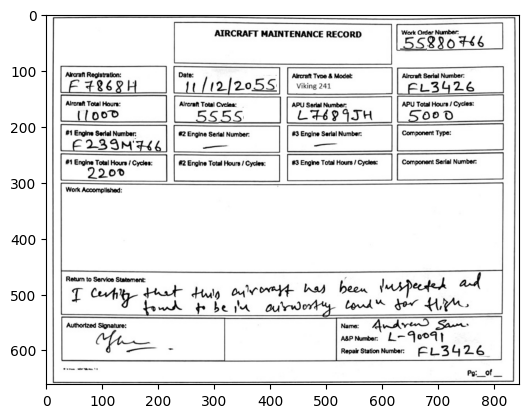

In [6]:
import re
import transformers
from PIL import Image
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import random
import numpy as np
from transformers.image_transforms import to_pil_image

# hidde logs
transformers.logging.disable_default_handler()


# Load our model from Hugging Face
processor = DonutProcessor.from_pretrained("1992anubhav/donut-base-engine_logbook")
model = VisionEncoderDecoderModel.from_pretrained("1992anubhav/donut-base-engine_logbook")

os.chdir('/content/drive/My Drive/Colab Notebooks/Test_Data')
image = Image.open('N001_test.jpg')
#image = plt.imread('list1.jpg')
plt.imshow(image)
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

# Move model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

#task_prompt = "<s_cord-v2>"
task_prompt = "<s>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

outputs = model.generate(pixel_values.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True,)

'''
# Load random document image from the test set
test_sample = processed_dataset["test"][random.randint(1, 50)]

def run_prediction(sample, model=model, processor=processor):
    # prepare inputs
    pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    # load reference target
    target = processor.token2json(test_sample["target_sequence"])
    return prediction, target

prediction, target = run_prediction(test_sample)
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")
pixel_values = np.squeeze(test_sample["pixel_values"])
#print(pixel_values)
pixel_values = (pixel_values + 1) / 2
#processor.feature_extractor.to_pil_image(pixel_values)
to_pil_image(pixel_values)
'''

In [7]:
sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
#sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(sequence)

'''prediction = processor.batch_decode(outputs.sequences)[0]
prediction =prediction.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")# processor.token2json(prediction)

print(prediction)'''


<s><s><s_Work Order No> 55880766</s_Work Order No><s_Repair Station No> CA426</s_Repair Station No><s_Engine Total Hours> 2200</s_Engine Total Hours><s_Engine Serial No> F239M766</s_Engine Serial No><s_Date> 11/12/2055</s_Date><s_Aircraft Type> Veiking 241</s_Aircraft Type><s_Aircraft Total Hours> 11000</s_Aircraft Total Hours><s_Aircraft Total Cycles> 5555</s_Aircraft Total Cycles><s_Aircraft Serial No> FL3426</s_Aircraft Serial No><s_Aircraft Registration No> F7868H</s_Aircraft Registration No>


'prediction = processor.batch_decode(outputs.sequences)[0]\nprediction =prediction.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")# processor.token2json(prediction)\n\nprint(prediction)'

Reference:
 {'Work Order No': 'JC42287634', 'Repair Station No': 'CA1312', 'Engine Total Hours': '1800', 'Engine Serial No': 'LM191434', 'Date': '01/08/2034', 'Aircraft Type': 'Cessna 206', 'Aircraft Total Hours': '3400', 'Aircraft Total Cycles': '2400', 'Aircraft Serial No': 'FG1418', 'Aircraft Registration No': 'N5391J'}
Prediction:
 {'Work Order No': 'JC42287634', 'Repair Station No': 'CA1312', 'Engine Total Hours': '1800', 'Engine Serial No': 'LM191434', 'Date': '01/08/2014', 'Aircraft Type': 'Cessna 206', 'Aircraft Total Hours': '3400', 'Aircraft Total Cycles': '2400', 'Aircraft Serial No': 'FG1418', 'Aircraft Registration No': 'N589J'}


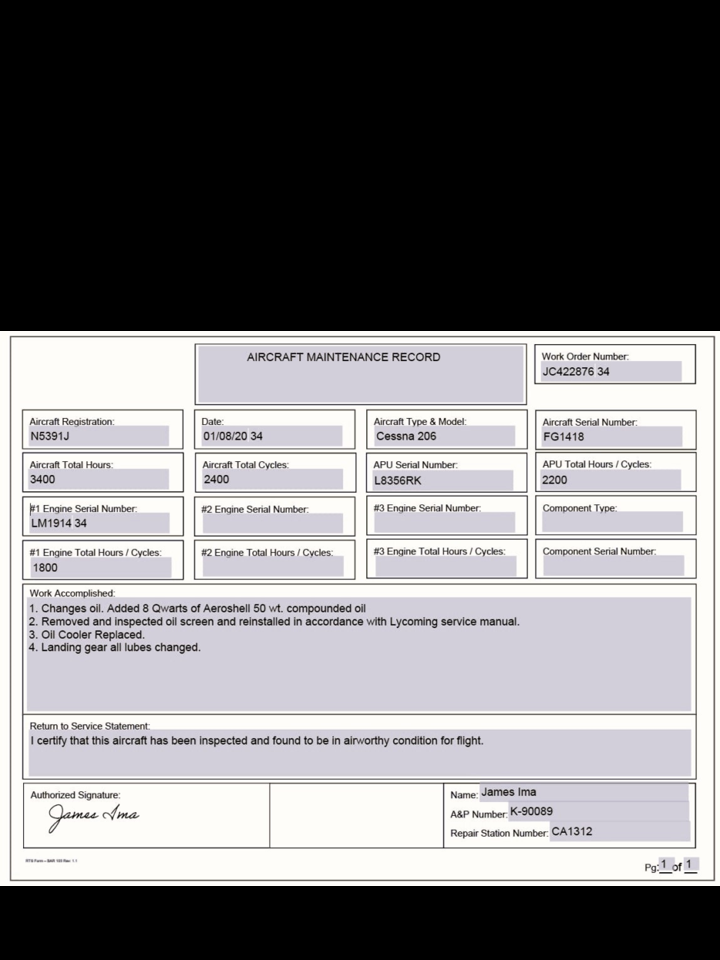

In [84]:
import re
import transformers
from PIL import Image
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import random
import numpy as np
from transformers.image_transforms import to_pil_image

# hidde logs
#transformers.logging.disable_default_handler()


# Load our model from Hugging Face
processor = DonutProcessor.from_pretrained("1992anubhav/donut-base-engine_logbook")
model = VisionEncoderDecoderModel.from_pretrained("1992anubhav/donut-base-engine_logbook")

test_sample = processed_dataset["test"][random.randint(1, 7)]
#print(pixel_values.shape)


def run_prediction(sample, model=model, processor=processor):
    # prepare inputs
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
        output_scores=True
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    # load reference target
    target = processor.token2json(test_sample["target_sequence"])
    return prediction, target

prediction, target = run_prediction(test_sample)
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")
pixel_values = np.squeeze(test_sample["pixel_values"])
#print(pixel_values)
pixel_values = (pixel_values + 1) / 2
#processor.feature_extractor.to_pil_image(pixel_values)
to_pil_image(pixel_values)

In [105]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

processor = DonutProcessor.from_pretrained("1992anubhav/donut-base-engine_logbook")
model = VisionEncoderDecoderModel.from_pretrained("1992anubhav/donut-base-engine_logbook")


def run_prediction1(sample, model=model, processor=processor):
    # prepare inputs
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    pixel_values = torch.tensor(sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
        output_scores=True
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    # load reference target
    target = processor.token2json(sample["target_sequence"])
    return prediction, target



# define counter for samples
true_counter = 0
total_counter = 0
y_test = [0] * 100
y_pred = [0] * 100
pred = False

# iterate over dataset
for sample in tqdm(processed_dataset["test"]):
  prediction, target = run_prediction1(sample)
  for s in zip(prediction.values(), target.values()):
    print("S[0]:S[1]",s[0], s[1])
    if s[0] == s[1]:
      true_counter += 1
      y_pred[true_counter] = 1
      pred = True
    total_counter += 1
    y_test[total_counter] = 1




print(f"Accuracy: {(true_counter/total_counter)*100}%")


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:649: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
 12%|█▎        | 1/8 [00:02<00:14,  2.00s/it]

S[0]:S[1] JC890110 JC890110
S[0]:S[1] CA1312 CA1312
S[0]:S[1] 1200 1200
S[0]:S[1] K413956 KH13956
S[0]:S[1] 05/06/2005 05/06/2005
S[0]:S[1] Cessna 182 Cessna 182
S[0]:S[1] 6500 6500
S[0]:S[1] 4200 4200
S[0]:S[1] KH7619 KH7619
S[0]:S[1] N1165S N1165S


 25%|██▌       | 2/8 [00:03<00:10,  1.81s/it]

S[0]:S[1] 1200 1200
S[0]:S[1] TFE75801 TFE75801
S[0]:S[1] F854401G F854401G
S[0]:S[1] Safran Safran
S[0]:S[1] 11/05/2008 11/05/2008
S[0]:S[1] L-197 L-197
S[0]:S[1] N223CA N223CA


 38%|███▊      | 3/8 [00:05<00:08,  1.75s/it]

S[0]:S[1] JC11204118 JC1120418
S[0]:S[1] CA1312 CA1312
S[0]:S[1] 2000 2000
S[0]:S[1] RW76651MM RW76651MK
S[0]:S[1] 08/12/2008 08/12/2008
S[0]:S[1] Pilling 257 Viking 287
S[0]:S[1] 9191 9191
S[0]:S[1] 8000 8000
S[0]:S[1] HM6418 HM8418
S[0]:S[1] G7388M G7388M


 50%|█████     | 4/8 [00:06<00:06,  1.70s/it]

S[0]:S[1] JC42287634 JC42287634
S[0]:S[1] CA1312 CA1312
S[0]:S[1] 1800 1800
S[0]:S[1] LM191434 LM191434
S[0]:S[1] 01/08/2014 01/08/2034
S[0]:S[1] Cessna 206 Cessna 206
S[0]:S[1] 3400 3400
S[0]:S[1] 2400 2400
S[0]:S[1] FG1418 FG1418
S[0]:S[1] N589J N5391J


 62%|██████▎   | 5/8 [00:08<00:04,  1.64s/it]

S[0]:S[1] 1200 1200
S[0]:S[1] IO-36098 IO-36098
S[0]:S[1] JH998 JH998
S[0]:S[1] Lycoming Lycoming
S[0]:S[1] 10/05/2012 10/05/2012
S[0]:S[1] J31C J31C
S[0]:S[1] N98YZ N98YZ


 75%|███████▌  | 6/8 [00:10<00:03,  1.64s/it]

S[0]:S[1] JC996883 JC996883
S[0]:S[1] HL68835 H31312
S[0]:S[1] 02/03/2016 1100
S[0]:S[1] Pilatus PC-24 HL68835
S[0]:S[1] 11000 02/03/2016
S[0]:S[1] 5000 Pilatus PC-24
S[0]:S[1] PC7689 11000
S[0]:S[1] H3535H 5000


 88%|████████▊ | 7/8 [00:11<00:01,  1.60s/it]

S[0]:S[1] 1200 1200
S[0]:S[1] NL-382 NL-382
S[0]:S[1] JH688 JH688
S[0]:S[1] Lycoming Lycoming
S[0]:S[1] 20/08/2014 20/08/2014
S[0]:S[1] J82PN J82PN
S[0]:S[1] N101HL N101HL


100%|██████████| 8/8 [00:13<00:00,  1.66s/it]

S[0]:S[1] JC422012 JC42201212
S[0]:S[1] CA1312 CA1312
S[0]:S[1] 2000 2000
S[0]:S[1] HG57RE HG567RE
S[0]:S[1] 05/11/2012 05/11/2012
S[0]:S[1] Cessna 206 Cessna 206
S[0]:S[1] 3200 3200
S[0]:S[1] 2300 2300
S[0]:S[1] KG6418 KG6418
S[0]:S[1] FY388M FY388M
Accuracy: 76.81159420289855%


y_test [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y_pred [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Total parameters Extracted: 69
Correctly Predicted: 53

Confusion matrix

 [[31  0]
 [16 53]]


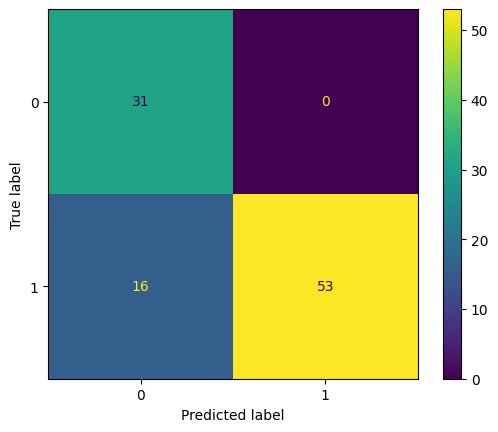

              precision    recall  f1-score   support

           0       0.66      1.00      0.79        31
           1       1.00      0.77      0.87        69

    accuracy                           0.84       100
   macro avg       0.83      0.88      0.83       100
weighted avg       0.89      0.84      0.85       100



In [106]:
#print(classification_report(target, prediction))
print("y_test", y_test)
print("y_pred", y_pred)
print("Total parameters Extracted:",total_counter)
print("Correctly Predicted:",true_counter)
cm = confusion_matrix(y_test, y_pred)
print('\nConfusion matrix\n\n', cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred))

torch.Size([1, 3, 2560, 1920])
{'question': 'what is the aircraft registration number?', 'answer': 'w7880k'}
{'question': 'What is date of installationD?', 'answer': '2/28/2011'}
{'question': 'Who is the engine manufacturer?', 'answer': 'repart station'}
{'question': 'What is the engine model number?', 'answer': 'ca 117'}
{'question': 'What is the blade design number?', 'answer': 'faa designee'}
{'question': 'What is the hub serial number?', 'answer': 'l897541'}


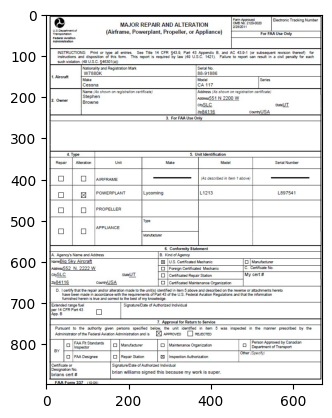

In [ ]:
import torch
import re
from transformers import DonutProcessor, VisionEncoderDecoderModel

os.chdir('/content/drive/My Drive/Colab Notebooks/Dataset/img')
image = Image.open('E017.jpg')
#image = plt.imread('list1.jpg')
plt.imshow(image)
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
questions = ["what is the aircraft registration number?",
            "What is date of installationD?",
            "Who is the engine manufacturer?",
            "What is the engine model number?",
            "What is the blade design number?",
            "What is the hub serial number?",
            ]

task_prompt = "<s_docvqa><s_question>{user_input}</s_question><s_answer>"
for each in questions:
    question = each
    prompt = task_prompt.replace("{user_input}", question)
    decoder_input_ids = processor.tokenizer(prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]
    outputs = model.generate(pixel_values.to(device),
                                decoder_input_ids=decoder_input_ids.to(device),
                                max_length=model.decoder.config.max_position_embeddings,
                                early_stopping=True,
                                pad_token_id=processor.tokenizer.pad_token_id,
                                eos_token_id=processor.tokenizer.eos_token_id,
                                use_cache=True,
                                num_beams=1,
                                bad_words_ids=[[processor.tokenizer.unk_token_id]],
                                return_dict_in_generate=True,
                                output_scores=True)
    seq = processor.batch_decode(outputs.sequences)[0]
    print(processor.token2json(seq))

In [ ]:
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")

questions = ["what is the address?",
            ]
pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)
task_prompt = "<s_docvqa><s_question>{user_input}</s_question><s_answer>"
for each in questions:
    question = each
    prompt = task_prompt.replace("{user_input}", question)
    decoder_input_ids = processor.tokenizer(prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]
    outputs = model.generate(pixel_values.to(device),
                                decoder_input_ids=decoder_input_ids.to(device),
                                max_length=model.decoder.config.max_position_embeddings,
                                early_stopping=True,
                                pad_token_id=processor.tokenizer.pad_token_id,
                                eos_token_id=processor.tokenizer.eos_token_id,
                                use_cache=True,
                                num_beams=1,
                                bad_words_ids=[[processor.tokenizer.unk_token_id]],
                                return_dict_in_generate=True,
                                output_scores=True)
    seq = processor.batch_decode(outputs.sequences)[0]
    print(processor.token2json(seq))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same